In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj


In [2]:
from plotting_helpers import load_ps_data

df_ps_dict = load_ps_data("hgp")

In [4]:
df_ps_dict["cluster_llr_norm_1"].head()

p_fail  delta_p_fail   p_abort  \
n   T p     seed cluster_llr_norm                                     
225 4 0.001 0    19.779867         0.162204      0.162204  0.999990   
                 24.551477         0.060322      0.060322  0.999970   
                 29.323088         0.020914      0.020914  0.999910   
                 34.094696         0.006449      0.006449  0.999704   
                 38.866310         0.002714      0.002714  0.999294   

                                   delta_p_abort  count  num_fails  \
n   T p     seed cluster_llr_norm                                    
225 4 0.001 0    19.779867              0.000006      8          0   
                 24.551477              0.000011     28          0   
                 29.323088              0.000018     88          0   
                 34.094696              0.000034    294          0   
                 38.866310              0.000052    704          0   

                                   p_fail_conv  delta_p_fail_conv  \
n   T p     seed cluster_llr_norm                                   
225 4 0.001 0    19.779867            0.019239           0.000851   
                 24.551477            0.019238           0.000851   
                 29.323088            0.019236           0.000851   
                 34.094696            0.019222           0.000850   
                 38.866310            0.019183           0.000848   

                                   p_abort_conv  delta_p_abort_conv  \
n   T p     seed cluster_llr_norm                                     
225 4 0.001 0    19.779867             0.899897            0.000588   
                 24.551477             0.899892            0.000588   
                 29.323088             0.899880            0.000588   
                 34.094696             0.899807            0.000588   
                 38.866310             0.899656            0.000589   

                                   count_conv  num_fails_conv  
n   T p     seed cluster_llr_norm                              
225 4 0.001 0    19.779867             100101            1924  
                 24.551477             100106            1924  
                 29.323088             100118            1924  
                 34.094696             100191            1924  
                 38.866310             100342            1923

## pfail vs pabort

In [15]:
from plotting_helpers import aggregate_seeds

df_ps_best_seed_dict = {}
for by, df_ps in df_ps_dict.items():
    df_ps_best_seed_dict[by] = aggregate_seeds(df_ps, use_pfail_upper=False)

In [16]:
df_ps_best_seed_dict["cluster_llr_norm_1"]

p_fail  delta_p_fail  seed
n   T p     p_abort                               
225 4 0.001 0.000002  0.138133      0.000676    70
            0.000002  0.108602      0.000610    24
            0.000002  0.106600      0.000605    65
            0.000002  0.094592      0.000574     8
            0.000003  0.094591      0.000574     8
...                        ...           ...   ...
            0.954418  0.002543      0.000460    27
            0.967832  0.002173      0.000505    27
            0.978271  0.001791      0.000555    27
            0.994704  0.001684      0.001043    27
            0.995543  0.001104      0.000875    58

[3887 rows x 3 columns]

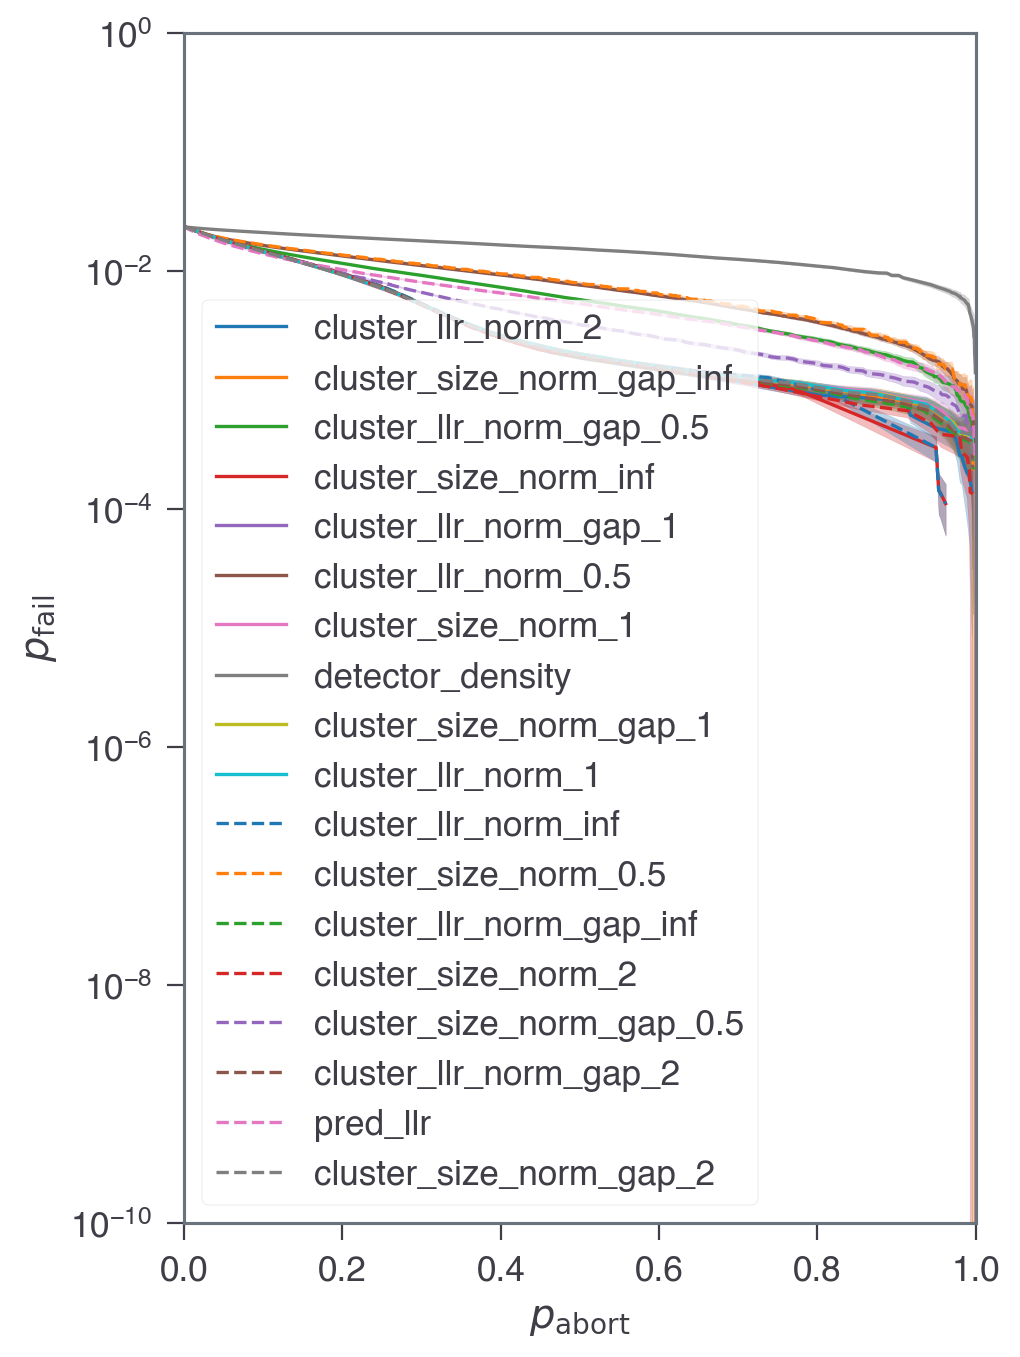

In [20]:
from plotting_helpers import error_band_plot

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 7))

n = 225
T = 12
p = 0.001

i = 0
data_plots = {}
for by, df_ps_all in df_ps_best_seed_dict.items():
    if True:
        p_abort_col = "p_abort"
        p_fail_col = "p_fail"
        delta_p_fail_col = "delta_p_fail"

        df_ps = df_ps_all.loc[idx[n, T, p, :], :].reset_index()

        df_ps = df_ps.sort_values(by=p_abort_col)
        p_abort = df_ps[p_abort_col].values
        p_fail = df_ps[p_fail_col].values / T
        delta_p_fail = df_ps[delta_p_fail_col].values / T
        data_plots[by] = (p_abort, p_fail, delta_p_fail)

        error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i % 10),
            linestyle="-" if i < 10 else "--",
            label=by,
            ax=ax,
        )
        i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()